In [1]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import itertools
from numpy import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import os
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import precision_score 
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [2]:
df1=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig01.dat')
df2=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig02.dat')
df3=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig03.dat')
df4=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig04.dat')
df5=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig05.dat')
df6=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig06.dat')
df7=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig07.dat')
df8=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig08.dat')
df9=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig09.dat')
df10=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig10.dat')
df11=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig11.dat')
df12=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig12.dat')
df13=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig13.dat')
df14=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig14.dat')
df15=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig15.dat')
df16=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig16.dat')
df17=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig17.dat')
df18=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig18.dat')
df19=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig19.dat')
df20=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig20.dat')
df21=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig21.dat')
df22=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig22.dat')
df23=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig23.dat')
df24=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig24.dat')
df25=np.loadtxt('/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig25.dat')


In [3]:
dff =[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23, df24, df25]

In [4]:
#Function to read the files and separate each AGN and its errors.

def agns(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=[] #AGNs
    err_agn=[] #AGNs errors
    star=[] #Calibration Stars
    err_star=[] #Calibration Stars errors
    agn_p=[] #Periodic AGNs
    err_agn_p=[] #Periodic AGNs errors

    for i in range(1, 544, 2):

        if i <  400: 
 
            agns = data[:,i]
            err_agns = data[:,i+1]
            agn.append(agns)
            err_agn.append(err_agns)
            
        elif i > 400 and i < 526:
   
            stars = data[:,i]
            err_stars = data[:,i+1]
            star.append(stars)
            err_star.append(err_stars)
            
        elif i > 526: 

            agn_ps = data[:,i]
            err_agn_ps = data[:,i+1]
            agn_p.append(agn_ps)
            err_agn_p.append(err_agn_ps)
            
    return agn, err_agn, star, err_star, agn_p, err_agn_p, t
                                       
    

In [5]:
#We calibrate the observed fluxes of the AGNs using the calibration stars.

#For this, we choose for each AGN the star that has the magnitude most similar to that of the AGN.


#We use the mean of each star and AGN for comparison. 


#We define a function that calculates the star with mean magnitude most similar to the AGN and then subtracts those magnitudes and this is what we will use to determine

#whether an AGN is variable or not.

def calibration(agn, star, err_agn, err_star):

    rest = []
    
    for i in range(63):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude

        err_cal = err_agn + err_star[ind_min]#Error calibrated magnitude 
        
    return cal, err_cal

In [6]:
def extract_features(mag, err_p, err_m):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
        'err_p_mag_mean': np.mean(err_p),
        'err_p_mag_var': np.var(err_p),
        'err_p_mag_skew': skew(err_p),
        'err_p_mag_kurt': kurtosis(err_p),
        'err_m_mag_mean': np.mean(err_m),
        'err_m_mag_var': np.var(err_m),
        'err_m_mag_skew': skew(err_m),
        'err_m_mag_kurt': kurtosis(err_m),
    }
    
    return features

In [7]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [8]:
#Observation times of each file.

t1 = agns(df1)[6]
t2 = agns(df2)[6]
t3 = agns(df3)[6]
t4 = agns(df4)[6]
t5 = agns(df5)[6]
t6 = agns(df6)[6]
t7 = agns(df7)[6]
t8 = agns(df8)[6]
t9 = agns(df9)[6]
t10 = agns(df10)[6]
t11 = agns(df11)[6]
t12 = agns(df12)[6]
t13 = agns(df13)[6]
t14 = agns(df14)[6]
t15 = agns(df15)[6]
t16 = agns(df16)[6]
t17 = agns(df17)[6]
t18 = agns(df18)[6]
t19 = agns(df19)[6]
t20 = agns(df20)[6]
t21 = agns(df21)[6]
t22 = agns(df22)[6]
t23 = agns(df23)[6]
t24 = agns(df24)[6]
t25 = agns(df25)[6]

In [9]:
#AGNs and each errors

agn1 = agns(df1)[0]
err_agn1 = agns(df1)[1]
agn2 = agns(df2)[0]
err_agn2 = agns(df2)[1]
agn3 = agns(df3)[0]
err_agn3 = agns(df3)[1]
agn4 = agns(df4)[0]
err_agn4 = agns(df4)[1]
agn5 = agns(df5)[0]
err_agn5 = agns(df5)[1]
agn6 = agns(df6)[0]
err_agn6 = agns(df6)[1]
agn7 = agns(df7)[0]
err_agn7 = agns(df7)[1]
agn8 = agns(df8)[0]
err_agn8 = agns(df8)[1]
agn9 = agns(df9)[0]
err_agn9 = agns(df9)[1]
agn10 = agns(df10)[0]
err_agn10 = agns(df10)[1]
agn11 = agns(df11)[0]
err_agn11 = agns(df11)[1]
agn12 = agns(df12)[0]
err_agn12 = agns(df12)[1]
agn13 = agns(df13)[0]
err_agn13 = agns(df13)[1]
agn14 = agns(df14)[0]
err_agn14 = agns(df14)[1]
agn15 = agns(df15)[0]
err_agn15 = agns(df15)[1]
agn16 = agns(df16)[0]
err_agn16 = agns(df16)[1]
agn17 = agns(df17)[0]
err_agn17 = agns(df17)[1]
agn18 = agns(df18)[0]
err_agn18 = agns(df18)[1]
agn19 = agns(df19)[0]
err_agn19 = agns(df19)[1]
agn20 = agns(df20)[0]
err_agn20 = agns(df20)[1]
agn21 = agns(df21)[0]
err_agn21 = agns(df21)[1]
agn22 = agns(df22)[0]
err_agn22 = agns(df22)[1]
agn23 = agns(df23)[0]
err_agn23 = agns(df23)[1]
agn24 = agns(df24)[0]
err_agn24 = agns(df24)[1]
agn25 = agns(df25)[0]
err_agn25 = agns(df25)[1]

In [10]:
#Calibration Stars and each errors

star1 = agns(df1)[2]
err_star1 = agns(df1)[3]
star2 = agns(df2)[2]
err_star2 = agns(df2)[3]
star3 = agns(df3)[2]
err_star3 = agns(df3)[3]
star4 = agns(df4)[2]
err_star4 = agns(df4)[3]
star5 = agns(df5)[2]
err_star5 = agns(df5)[3]
star6 = agns(df6)[2]
err_star6 = agns(df6)[3]
star7 = agns(df7)[2]
err_star7 = agns(df7)[3]
star8 = agns(df8)[2]
err_star8 = agns(df8)[3]
star9 = agns(df9)[2]
err_star9 = agns(df9)[3]
star10 = agns(df10)[2]
err_star10 = agns(df10)[3]
star11 = agns(df11)[2]
err_star11 = agns(df11)[3]
star12 = agns(df12)[2]
err_star12 = agns(df12)[3]
star13 = agns(df13)[2]
err_star13 = agns(df13)[3]
star14 = agns(df14)[2]
err_star14 = agns(df14)[3]
star15 = agns(df15)[2]
err_star15 = agns(df15)[3]
star16 = agns(df16)[2]
err_star16 = agns(df16)[3]
star17 = agns(df17)[2]
err_star17 = agns(df17)[3]
star18 = agns(df18)[2]
err_star18 = agns(df18)[3]
star19 = agns(df19)[2]
err_star19 = agns(df19)[3]
star20 = agns(df20)[2]
err_star20 = agns(df20)[3]
star21 = agns(df21)[2]
err_star21 = agns(df21)[3]
star22 = agns(df22)[2]
err_star22 = agns(df22)[3]
star23 = agns(df23)[2]
err_star23 = agns(df23)[3]
star24 = agns(df24)[2]
err_star24 = agns(df24)[3]
star25 = agns(df25)[2]
err_star25 = agns(df25)[3]

In [11]:
#Varables AGNs an each errors

agn_p1 = agns(df1)[4]
err_agn_p1 = agns(df1)[5]
agn_p2 = agns(df2)[4]
err_agn_p2 = agns(df2)[5]
agn_p3 = agns(df3)[4]
err_agn_p3 = agns(df3)[5]
agn_p4 = agns(df4)[4]
err_agn_p4 = agns(df4)[5]
agn_p5 = agns(df5)[4]
err_agn_p5 = agns(df5)[5]
agn_p6 = agns(df6)[4]
err_agn_p6 = agns(df6)[5]
agn_p7 = agns(df7)[4]
err_agn_p7 = agns(df7)[5]
agn_p8 = agns(df8)[4]
err_agn_p8 = agns(df8)[5]
agn_p9 = agns(df9)[4]
err_agn_p9 = agns(df9)[5]
agn_p10 = agns(df10)[4]
err_agn_p10 = agns(df10)[5]
agn_p11 = agns(df11)[4]
err_agn_p11 = agns(df11)[5]
agn_p12 = agns(df12)[4]
err_agn_p12 = agns(df12)[5]
agn_p13 = agns(df13)[4]
err_agn_p13 = agns(df13)[5]
agn_p14 = agns(df14)[4]
err_agn_p14 = agns(df14)[5]
agn_p15 = agns(df15)[4]
err_agn_p15 = agns(df15)[5]
agn_p16 = agns(df16)[4]
err_agn_p16 = agns(df16)[5]
agn_p17 = agns(df17)[4]
err_agn_p17 = agns(df17)[5]
agn_p18 = agns(df18)[4]
err_agn_p18 = agns(df18)[5]
agn_p19 = agns(df19)[4]
err_agn_p19 = agns(df19)[5]
agn_p20 = agns(df20)[4]
err_agn_p20 = agns(df20)[5]
agn_p21 = agns(df21)[4]
err_agn_p21 = agns(df21)[5]
agn_p22 = agns(df22)[4]
err_agn_p22 = agns(df22)[5]
agn_p23 = agns(df23)[4]
err_agn_p23 = agns(df23)[5]
agn_p24 = agns(df24)[4]
err_agn_p24 = agns(df24)[5]
agn_p25 = agns(df25)[4]
err_agn_p25 = agns(df25)[5]

In [24]:
#Create an save the dataframe to a CSV file

def dataframe(df, N, p, star, err_star, c, x): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset

        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        err_p = mag + err_mag
        err_m = mag - err_mag
        
        # Extract features from the time series data
        features = extract_features(mag, err_p, err_m)
        
        # Store the features and the target variable
        data_features.append(features)

        if p == 1:
            variability.append(1)
        else:
            variability.append(0)

    return data_features

In [25]:
#First whit the non-variable AGNs

data_features = []
data_features_p = []
variability = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 200, 0, star, err_star, 0, 1)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [26]:
#Then with the variable AGNs

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 9, 1, star, err_star, 4, 5)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [27]:
features_df

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
0,0.010450,0.000020,-0.233428,-0.543255,0.016450,0.000020,-0.233428,-0.543255,0.004450,0.000020,-0.233428,-0.543255,0
1,-0.014100,0.000017,-0.209839,0.418627,-0.008100,0.000017,-0.209839,0.418627,-0.020100,0.000017,-0.209839,0.418627,0
2,-0.009125,0.000016,0.335852,-0.078736,-0.003125,0.000016,0.335852,-0.078736,-0.015125,0.000016,0.335852,-0.078736,0
3,-0.004100,0.000017,-0.199723,-0.703788,0.001900,0.000017,-0.199723,-0.703788,-0.010100,0.000017,-0.199723,-0.703788,0
4,0.000325,0.000013,-0.097803,-0.743768,0.006325,0.000013,-0.097803,-0.743768,-0.005675,0.000013,-0.097803,-0.743768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,0.013825,0.006252,-0.131830,-1.091343,0.030025,0.006243,-0.145639,-1.101369,-0.002375,0.006280,-0.118861,-1.075591,1
5221,-0.012100,0.004425,-0.281331,-1.361673,0.004100,0.004470,-0.292878,-1.350930,-0.028300,0.004399,-0.264609,-1.367214,1
5222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,-0.004375,0.001547,-0.180160,0.470815,1
5223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,-0.030650,0.001103,-0.060833,-1.125633,1


In [28]:
features_df.isna().sum()

mag_mean          0
mag_var           0
mag_skew          0
mag_kurt          0
err_p_mag_mean    0
err_p_mag_var     0
err_p_mag_skew    0
err_p_mag_kurt    0
err_m_mag_mean    0
err_m_mag_var     0
err_m_mag_skew    0
err_m_mag_kurt    0
Variability       0
dtype: int64

In [29]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [30]:
features_df.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.981870,-0.039593,0.048969,0.025883,0.978575,-0.036943,0.001821,0.027471,-0.100698
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.023797,0.999149,-0.067844,-0.155983,-0.059328,0.998679,-0.040626,-0.160259,0.756343
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.016450,-0.053768,0.833663,0.225264,0.036321,-0.069904,0.852010,-0.131266,-0.094039
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.064135,-0.152355,0.265941,0.894173,-0.011460,-0.150304,-0.173598,0.896775,-0.218651
err_p_mag_mean,0.981870,-0.023797,0.016450,0.064135,1.000000,-0.018835,0.090943,0.059622,0.921806,-0.014338,-0.050480,0.060505,-0.109615
err_p_mag_var,-0.039593,0.999149,-0.053768,-0.152355,-0.018835,1.000000,-0.055640,-0.149188,-0.060513,0.997345,-0.044902,-0.154524,0.753628
err_p_mag_skew,0.048969,-0.067844,0.833663,0.265941,0.090943,-0.055640,1.000000,0.428347,0.001364,-0.062443,0.459982,0.118510,-0.155117
err_p_mag_kurt,0.025883,-0.155983,0.225264,0.894173,0.059622,-0.149188,0.428347,1.000000,-0.011827,-0.148516,-0.036637,0.665208,-0.212685
err_m_mag_mean,0.978575,-0.059328,0.036321,-0.011460,0.921806,-0.060513,0.001364,-0.011827,1.000000,-0.059977,0.058556,-0.009540,-0.086872
err_m_mag_var,-0.036943,0.998679,-0.069904,-0.150304,-0.014338,0.997345,-0.062443,-0.148516,-0.059977,1.000000,-0.056754,-0.152697,0.751556


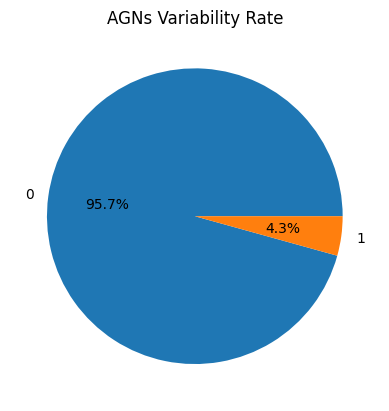

In [31]:
pie_x, pie_y = np.unique(features_df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

#### As we can see, this dataset is very unbalanced.

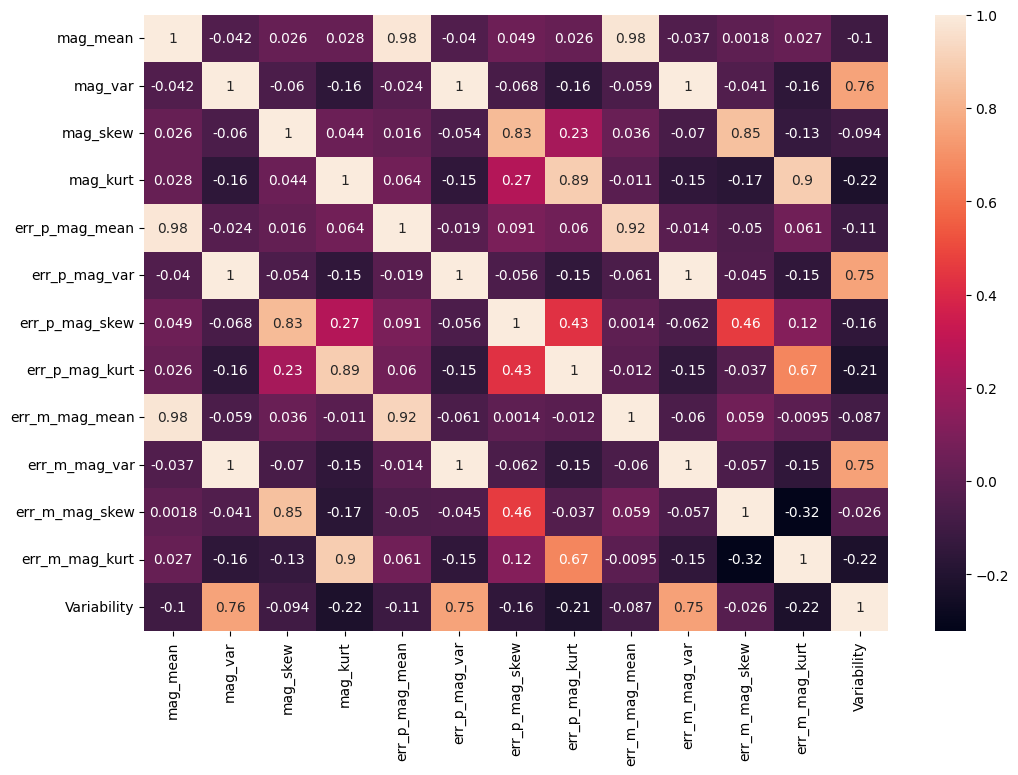

In [32]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df.corr(), annot=True)
plt.show()

In [33]:
features_df.Variability.value_counts()

Variability
0    5000
1     225
Name: count, dtype: int64

In [34]:
df_0 = features_df[features_df['Variability'] == 0 ].sample(n=500)

In [35]:
df_0

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
320,0.010650,0.000035,0.102364,-0.869896,0.018675,0.000035,0.146713,-0.946913,0.002625,0.000036,0.051723,-0.769561,0
3506,0.000125,0.000072,0.488720,0.690566,0.010925,0.000078,0.523178,0.192653,-0.010675,0.000072,0.359201,1.029649,0
974,0.009125,0.000036,-0.197421,-0.899011,0.019250,0.000036,-0.238991,-0.934051,-0.001000,0.000035,-0.145953,-0.888918,0
1561,0.003750,0.000034,0.315329,-0.562472,0.013750,0.000034,0.315329,-0.562472,-0.006250,0.000034,0.315329,-0.562472,0
2942,0.000400,0.000046,-0.382336,0.159627,0.010525,0.000047,-0.177044,-0.210334,-0.009725,0.000047,-0.550405,0.579699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,-0.005900,0.000037,0.313580,0.352010,0.002425,0.000046,0.375483,0.307790,-0.014225,0.000034,0.085311,0.242845,0
572,-0.000550,0.000041,0.553688,0.318651,0.009450,0.000041,0.553688,0.318651,-0.010550,0.000041,0.553688,0.318651,0
1475,-0.004250,0.000015,-0.460083,0.541343,0.003750,0.000015,-0.460083,0.541343,-0.012250,0.000015,-0.460083,0.541343,0
527,-0.015250,0.000029,0.234666,0.075837,-0.007100,0.000029,0.203484,0.060782,-0.023400,0.000029,0.262003,0.061309,0


In [36]:
df_1 =  features_df[features_df['Variability'] == 1 ].sample(n=216)

In [37]:
df_1

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
5202,0.000025,0.007785,-0.268462,-1.091402,0.018875,0.007722,-0.267553,-1.068100,-0.018825,0.007853,-0.269260,-1.112539,1
5127,-0.012775,0.003341,-0.006055,-1.227237,-0.006000,0.003309,-0.034327,-1.205162,-0.019550,0.003374,0.021192,-1.248229,1
5223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,-0.030650,0.001103,-0.060833,-1.125633,1
5018,-0.012150,0.003340,0.032585,-1.207149,-0.006150,0.003340,0.032585,-1.207149,-0.018150,0.003340,0.032585,-1.207149,1
5175,-0.007925,0.005771,-0.039005,-0.418268,-0.000125,0.005815,-0.039427,-0.422284,-0.015725,0.005730,-0.038434,-0.414154,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5077,0.009375,0.003169,-0.099455,-0.837997,0.016375,0.003169,-0.099455,-0.837997,0.002375,0.003169,-0.099455,-0.837997,1
5080,-0.007375,0.000158,0.465284,-0.029297,-0.000375,0.000158,0.465284,-0.029297,-0.014375,0.000158,0.465284,-0.029297,1
5059,-0.011350,0.002790,-0.215478,-0.756651,-0.004325,0.002794,-0.213369,-0.756449,-0.018375,0.002786,-0.217515,-0.756719,1
5055,-0.013125,0.003337,-0.001419,-1.203329,-0.007125,0.003337,-0.001419,-1.203329,-0.019125,0.003337,-0.001419,-1.203329,1


In [38]:
df = pd.concat([df_0, df_1])

In [39]:
df.index =  range(df.shape[0])

In [40]:
df

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Variability
0,0.010650,0.000035,0.102364,-0.869896,0.018675,0.000035,0.146713,-0.946913,0.002625,0.000036,0.051723,-0.769561,0
1,0.000125,0.000072,0.488720,0.690566,0.010925,0.000078,0.523178,0.192653,-0.010675,0.000072,0.359201,1.029649,0
2,0.009125,0.000036,-0.197421,-0.899011,0.019250,0.000036,-0.238991,-0.934051,-0.001000,0.000035,-0.145953,-0.888918,0
3,0.003750,0.000034,0.315329,-0.562472,0.013750,0.000034,0.315329,-0.562472,-0.006250,0.000034,0.315329,-0.562472,0
4,0.000400,0.000046,-0.382336,0.159627,0.010525,0.000047,-0.177044,-0.210334,-0.009725,0.000047,-0.550405,0.579699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.009375,0.003169,-0.099455,-0.837997,0.016375,0.003169,-0.099455,-0.837997,0.002375,0.003169,-0.099455,-0.837997,1
712,-0.007375,0.000158,0.465284,-0.029297,-0.000375,0.000158,0.465284,-0.029297,-0.014375,0.000158,0.465284,-0.029297,1
713,-0.011350,0.002790,-0.215478,-0.756651,-0.004325,0.002794,-0.213369,-0.756449,-0.018375,0.002786,-0.217515,-0.756719,1
714,-0.013125,0.003337,-0.001419,-1.203329,-0.007125,0.003337,-0.001419,-1.203329,-0.019125,0.003337,-0.001419,-1.203329,1


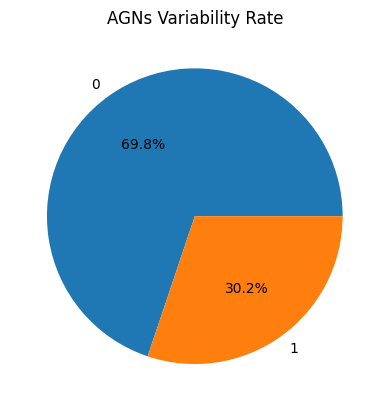

In [41]:
pie_x, pie_y = np.unique(df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

### Machine Learning models

In [42]:
#Apply a Machine Learning model, a Logistic Regression.

data1 = features_df.copy()

X = data1.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data1['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
clf = LogisticRegression(random_state=0)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
r2_score(y_pred, y_test)

-1.6738798071268954

We'll try to improve the model.

In [43]:
#Apply a Random Forest classifier with the original dataset.

data = features_df.copy()

# Split the data into features and target
X = data.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data['Variability']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_score(y_pred,y_test)

0.9961734693877551

In [44]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = df.drop('Variability', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = df['Variability']

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier1 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier1.fit(X1_train, y1_train)

# Make predictions on the test set
y1_pred = rf_classifier1.predict(X1_test)

# Evaluate the model
accuracy_score(y1_pred,y1_test)

0.9930555555555556

#### We use the metrics to evaluate the model

Metrics of first Random Forest Model

In [45]:
confusion = metrics.confusion_matrix(y_test, y_pred)
confusion.ravel()

array([1499,    1,    5,   63])

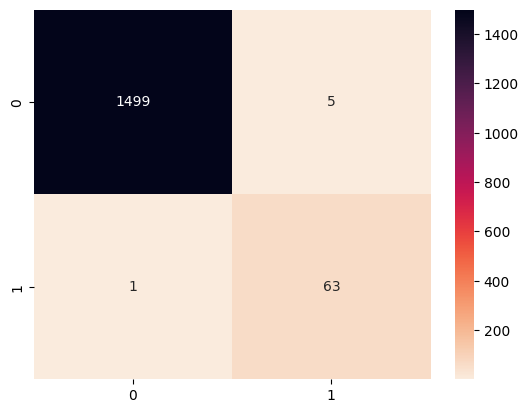

In [46]:
mc=confusion_matrix(y_pred,y_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [47]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='precision')

array([1.        , 1.        , 0.97727273])

In [48]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='precision').mean()

0.9924242424242425

In [49]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='recall')

array([0.92307692, 0.96153846, 0.81132075])

In [50]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='recall').mean()

0.8922351233671989

In [51]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='f1')

array([0.96      , 0.97029703, 0.88659794])

In [52]:
cross_val_score(rf_classifier,X_train,y_train,cv=3,scoring='f1').mean()

0.9354633057807499

Metrics of second Random Forest Model

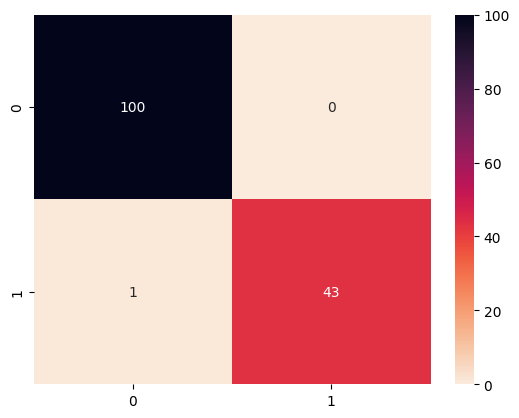

In [53]:
mc=confusion_matrix(y1_pred,y1_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [54]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='precision')

array([0.98275862, 0.94736842, 0.98181818])

In [55]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='precision').mean()

0.9763955342902711

In [56]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='recall')

array([0.96551724, 0.93103448, 0.96491228])

In [57]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='recall').mean()

0.9479733817301875

In [58]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='f1')

array([0.97391304, 0.93913043, 0.97345133])

In [59]:
cross_val_score(rf_classifier1,X1_train,y1_train,cv=3,scoring='f1').mean()

0.9591097308488612

#### The second Random Forest model its better, so we will use this one.

In [60]:
#Precision score
precision_score(y1_pred, y1_test)

1.0

In [61]:
#Specificity score
specificity_score(y1_pred,y1_test)

1.0

In [62]:
#ROC AUC score
roc_auc_score(y1_pred,y1_test)

0.9886363636363636

In [63]:
#Recall score
recall_score(y1_test, y1_pred) 

1.0

In [64]:
#F1 score
f1_score(y1_test, y1_pred) 

0.9885057471264368

In [65]:
print(classification_report(y1_test,y1_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       101
           1       0.98      1.00      0.99        43

    accuracy                           0.99       144
   macro avg       0.99      1.00      0.99       144
weighted avg       0.99      0.99      0.99       144



### Now we'll use real observations of some AGNs to classify them.  

In [66]:
#Function to read the observations and separate each AGN and calibration Stars.

def agns1(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=data[:,1] #AGN magnitude
    cal_star=[] #Calibration Stars
    
    for i in range(2, 9, 1):

        if i != 6 and i != 8:

            stars = data[:,i]
            cal_star.append(stars)

    return agn, cal_star, t

In [67]:
def calibration1(agn, star):

    rest = []
    
    for i in range(5):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude
            
    return cal

In [68]:
def subsample_time_series(mag, t, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: AGN magnitudes
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data mag.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return mag[subsample_indices], t[subsample_indices]

In [69]:
def extract_features_obs(mag):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
    }
    
    return features

In [70]:
#Create a dataframe for the observations an save it to a CSV file

def dataframe_obs(df, star): 
    
    subsample_size = 30
    agn = agns1(df)[0]
    t= agns1(df)[2]

    #Calculates the calibrated magnitude of the AGN
    mag = calibration1(agn, star)
  
    # Subsample the time series data to simulate incomplete observations
    #mag_subsampled = subsample_time_series(mag, t, subsample_size)        
    
    # Extract features from the time series data
    features_obs = extract_features_obs(mag)
        
    return features_obs

In [71]:
#List all the AGNs, each one is a directory

dir = '/home/anakin/Documents/Tesis/Codigo/obs/'
names_agns = os.listdir(dir)
names_agns 

['agn_1331',
 'agn_1349',
 'agn_1424',
 'agn_0537',
 'agn_0637',
 'agn_0521',
 'agn_1229',
 'agn_2344',
 'agn_2341',
 'agn_1125',
 'agn_1510',
 'agn_1256',
 'agn_1144',
 'agn_2200',
 'agn_0208',
 'agn_1606',
 'agn_1101',
 'agn_2316',
 'agn_3c279',
 'agn_2347',
 'agn_2005',
 'agn_1243',
 'agn_2254',
 'agn_1120',
 'agn_1244',
 'agn_1127',
 'agn_1741',
 'agn_3c273',
 'agn_1034',
 'agn_1334',
 'agn_2155',
 'agn_1622',
 'agn_2022',
 'agn_1933',
 'agn_1157',
 'agn_2340',
 'agn_2230',
 'agn_0235',
 'agn_2320']

In [72]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/obs/' #path to main directory
filelist = os.listdir(path)
df_obs = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.dat'):
            file = np.loadtxt(i+j, skiprows=5)
            long= len(file[:,0])

            data_features_obs = []

            star = agns1(file)[1]

            features_obs = dataframe_obs(file, star)

            # Store the features and the target variable
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_obs = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted = rf_classifier1.predict(features_df_obs)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs.to_csv('observations_AGNs.csv', index=False)


1331_n1E4.dat :Classified [0] with 30 observations
1331_n1E5.dat :Classified [0] with 30 observations
1331_n1E12.dat :Classified [0] with 30 observations
1331_n1E10.dat :Classified [0] with 30 observations
1331_n1E9.dat :Classified [0] with 30 observations
1331_n1E2.dat :Classified [0] with 30 observations
1331_n1E3.dat :Classified [0] with 30 observations
1331_n1E6.dat :Classified [0] with 30 observations
1331_n1E11.dat :Classified [0] with 30 observations
------------------------------------------------- agn_1331 is variable whit a probability of: 0.0 %
1349_n1E14.dat :Classified [1] with 14 observations
1349_n1E15.dat :Classified [1] with 14 observations
1349_n1E12.dat :Classified [1] with 14 observations
1349_n1E8.dat :Classified [1] with 14 observations
1349_n1E17.dat :Classified [1] with 14 observations
1349_n1E20.dat :Classified [1] with 14 observations
1349_n1E10.dat :Classified [1] with 14 observations
1349_n1E5.dat :Classified [1] with 14 observations
1349_n1E9.dat :Classifie

In [73]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs
0,-0.045714,0.000399,-0.343918,-1.163982,1349_n1E14.dat
1,-0.045714,0.000399,-0.343918,-1.163982,1349_n1E15.dat
2,-0.045714,0.000399,-0.343918,-1.163982,1349_n1E12.dat
3,-0.045714,0.000399,-0.343918,-1.163982,1349_n1E8.dat
4,-0.045714,0.000399,-0.343918,-1.163982,1349_n1E17.dat
...,...,...,...,...,...
325,0.509818,0.000935,0.694997,-0.172982,0235_n4E4.dat
326,-0.065300,0.000673,-0.097026,-1.024178,0235_n7E12.dat
327,0.307000,0.002706,0.893804,0.789084,0235_n8E8.dat
328,-0.108667,0.000733,0.034979,-0.548334,0235_n6E10.dat


### Now we perform a model to classify periodics AGNs.

In [74]:
#Create an save the dataframe to a CSV file

def dataframe1(df, N, p, star, err_star, c, x, a): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset
        p = 0
        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        err_p = mag + err_mag
        err_m = mag - err_mag
        
        # Extract features from the time series data
        features = extract_features(mag, err_p, err_m)
        
        # Store the features and the target variable
        data_features1.append(features)

        if i == 4 and a == 3:

            p = 1
        
        if p == 1:
            
            Periodicity.append(1)
        else:
            
            Periodicity.append(0)

    return data_features1

In [113]:
#First whit the non-periodic AGNs

data_features1 = []
Periodicity = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features1 = dataframe1(dt, 200, 0, star, err_star, 0, 1, 0)

    # Convert lists to a DataFrame
    features_df1 = pd.DataFrame(data_features1)
    features_df1['Periodicity'] = Periodicity       

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [114]:
#Then with the periodics AGNs

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features1 = dataframe1(dt, 9, 0, star, err_star, 4, 5, 3)

    # Convert lists to a DataFrame
    features_df1 = pd.DataFrame(data_features1)
    features_df1['Periodicity'] = Periodicity       


In [115]:
features_df1

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
0,0.010450,0.000020,-0.233428,-0.543255,0.016450,0.000020,-0.233428,-0.543255,0.004450,0.000020,-0.233428,-0.543255,0
1,-0.014100,0.000017,-0.209839,0.418627,-0.008100,0.000017,-0.209839,0.418627,-0.020100,0.000017,-0.209839,0.418627,0
2,-0.009125,0.000016,0.335852,-0.078736,-0.003125,0.000016,0.335852,-0.078736,-0.015125,0.000016,0.335852,-0.078736,0
3,-0.004100,0.000017,-0.199723,-0.703788,0.001900,0.000017,-0.199723,-0.703788,-0.010100,0.000017,-0.199723,-0.703788,0
4,0.000325,0.000013,-0.097803,-0.743768,0.006325,0.000013,-0.097803,-0.743768,-0.005675,0.000013,-0.097803,-0.743768,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,0.013825,0.006252,-0.131830,-1.091343,0.030025,0.006243,-0.145639,-1.101369,-0.002375,0.006280,-0.118861,-1.075591,1
5221,-0.012100,0.004425,-0.281331,-1.361673,0.004100,0.004470,-0.292878,-1.350930,-0.028300,0.004399,-0.264609,-1.367214,0
5222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,-0.004375,0.001547,-0.180160,0.470815,0
5223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,-0.030650,0.001103,-0.060833,-1.125633,0


In [116]:
features_df.isna().sum()

mag_mean          0
mag_var           0
mag_skew          0
mag_kurt          0
err_p_mag_mean    0
err_p_mag_var     0
err_p_mag_skew    0
err_p_mag_kurt    0
err_m_mag_mean    0
err_m_mag_var     0
err_m_mag_skew    0
err_m_mag_kurt    0
Variability       0
dtype: int64

In [117]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [118]:
features_df1.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.981870,-0.039593,0.048969,0.025883,0.978575,-0.036943,0.001821,0.027471,-0.015686
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.023797,0.999149,-0.067844,-0.155983,-0.059328,0.998679,-0.040626,-0.160259,0.753686
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.016450,-0.053768,0.833663,0.225264,0.036321,-0.069904,0.852010,-0.131266,-0.006427
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.064135,-0.152355,0.265941,0.894173,-0.011460,-0.150304,-0.173598,0.896775,-0.088703
err_p_mag_mean,0.981870,-0.023797,0.016450,0.064135,1.000000,-0.018835,0.090943,0.059622,0.921806,-0.014338,-0.050480,0.060505,-0.017345
err_p_mag_var,-0.039593,0.999149,-0.053768,-0.152355,-0.018835,1.000000,-0.055640,-0.149188,-0.060513,0.997345,-0.044902,-0.154524,0.751296
err_p_mag_skew,0.048969,-0.067844,0.833663,0.265941,0.090943,-0.055640,1.000000,0.428347,0.001364,-0.062443,0.459982,0.118510,-0.028183
err_p_mag_kurt,0.025883,-0.155983,0.225264,0.894173,0.059622,-0.149188,0.428347,1.000000,-0.011827,-0.148516,-0.036637,0.665208,-0.086226
err_m_mag_mean,0.978575,-0.059328,0.036321,-0.011460,0.921806,-0.060513,0.001364,-0.011827,1.000000,-0.059977,0.058556,-0.009540,-0.013239
err_m_mag_var,-0.036943,0.998679,-0.069904,-0.150304,-0.014338,0.997345,-0.062443,-0.148516,-0.059977,1.000000,-0.056754,-0.152697,0.750245


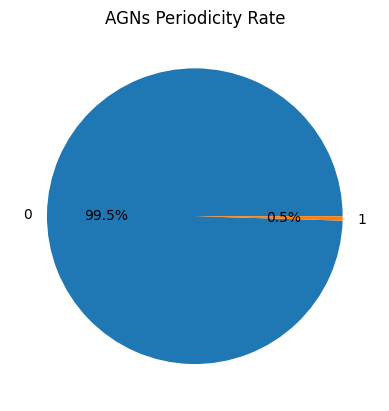

In [119]:
pie_x, pie_y = np.unique(features_df1['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

#### This dataset is very unbalanced.

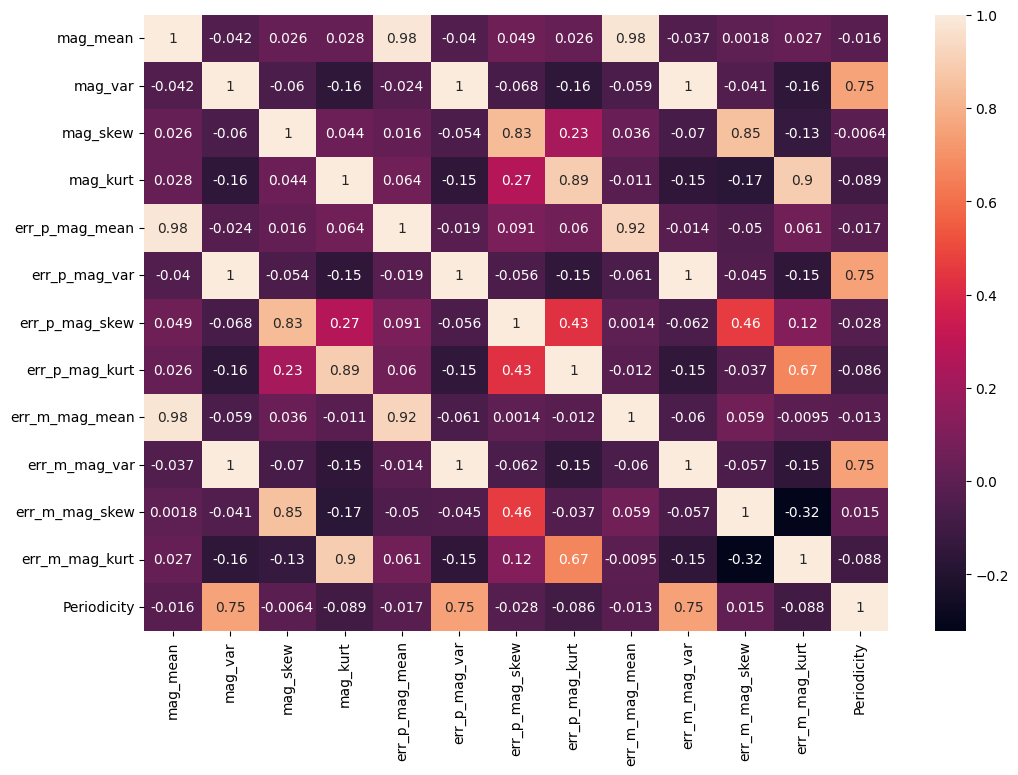

In [120]:
#Perform a correlation matrix to see how the data are related.

plt.figure(figsize=(12,8))
sns.heatmap(features_df1.corr(), annot=True)
plt.show()

In [121]:
features_df1['Periodicity'].value_counts()

Periodicity
0    5200
1      25
Name: count, dtype: int64

In [122]:
df_2 = features_df1[features_df1['Periodicity'] == 0 ].sample(n=100)

In [123]:
df_2

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
3743,0.005950,0.000051,0.047689,-0.208781,0.016125,0.000059,0.199453,-0.277942,-0.004225,0.000049,-0.167663,-0.013434,0
4871,0.001975,0.000154,0.361184,1.161954,0.017700,0.000171,0.764629,1.231935,-0.013750,0.000149,-0.142885,1.353937,0
1443,-0.013625,0.000023,0.335065,-0.186865,-0.007525,0.000022,0.347253,-0.081173,-0.019725,0.000024,0.281251,-0.254105,0
746,-0.009800,0.000029,0.375339,-0.400243,0.000175,0.000029,0.361403,-0.417404,-0.019775,0.000029,0.382949,-0.378165,0
4971,0.000600,0.000326,-0.031858,0.277188,0.024775,0.000369,-0.085847,0.227968,-0.023575,0.000318,0.038035,0.087671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,0.008150,0.000023,-0.092921,-0.933976,0.016250,0.000024,-0.037786,-0.854301,0.000050,0.000024,-0.143018,-0.909318,0
1983,0.054875,0.000063,0.273502,-0.488964,0.065175,0.000063,0.225068,-0.580251,0.044575,0.000063,0.315764,-0.410133,0
1536,0.001025,0.000041,0.591437,-0.433066,0.009425,0.000043,0.528218,-0.544812,-0.007375,0.000041,0.640129,-0.330430,0
1555,0.007575,0.000062,-0.040385,-0.292939,0.017575,0.000062,-0.040385,-0.292939,-0.002425,0.000062,-0.040385,-0.292939,0


In [124]:
df_3 = features_df1[features_df1['Periodicity'] == 1 ].sample(n=24)

In [125]:
df_3

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
5220,0.013825,0.006252,-0.131830,-1.091343,0.030025,0.006243,-0.145639,-1.101369,-0.002375,0.006280,-0.118861,-1.075591,1
5112,0.009675,0.007795,-0.276758,-1.315512,0.018600,0.007810,-0.272248,-1.319308,0.000750,0.007781,-0.281132,-1.311581,1
5166,0.013075,0.007453,-0.326449,-1.017086,0.021100,0.007480,-0.324646,-1.012127,0.005050,0.007428,-0.327876,-1.021136,1
5013,-0.000700,0.008589,0.020419,-1.202122,0.006375,0.008577,0.022124,-1.205079,-0.007775,0.008600,0.018684,-1.199088,1
5058,0.001350,0.008520,-0.129726,-1.245811,0.008425,0.008520,-0.132114,-1.245390,-0.005725,0.008520,-0.127335,-1.246280,1
5004,0.007700,0.007092,-0.257085,-1.003337,0.014775,0.007092,-0.257241,-1.000765,0.000625,0.007092,-0.256923,-1.005875,1
5139,-0.005700,0.006030,0.034774,-0.648226,0.008500,0.006011,0.040444,-0.654243,-0.019900,0.006050,0.029158,-0.641971,1
5031,0.014775,0.010538,-0.032830,-1.185725,0.021775,0.010538,-0.032830,-1.185725,0.007775,0.010538,-0.032830,-1.185725,1
5148,-0.003650,0.007777,-0.071726,-1.165286,0.004575,0.007788,-0.073519,-1.154642,-0.011875,0.007771,-0.069974,-1.174673,1
5067,0.008525,0.008751,0.247274,-1.406739,0.015550,0.008746,0.247463,-1.406361,0.001500,0.008756,0.247067,-1.407101,1


In [126]:
dfn = pd.concat([df_2, df_3])

In [127]:
dfn.index =  range(dfn.shape[0])

In [128]:
dfn

,mag_mean,mag_var,mag_skew,mag_kurt,err_p_mag_mean,err_p_mag_var,err_p_mag_skew,err_p_mag_kurt,err_m_mag_mean,err_m_mag_var,err_m_mag_skew,err_m_mag_kurt,Periodicity
0,0.005950,0.000051,0.047689,-0.208781,0.016125,0.000059,0.199453,-0.277942,-0.004225,0.000049,-0.167663,-0.013434,0
1,0.001975,0.000154,0.361184,1.161954,0.017700,0.000171,0.764629,1.231935,-0.013750,0.000149,-0.142885,1.353937,0
2,-0.013625,0.000023,0.335065,-0.186865,-0.007525,0.000022,0.347253,-0.081173,-0.019725,0.000024,0.281251,-0.254105,0
3,-0.009800,0.000029,0.375339,-0.400243,0.000175,0.000029,0.361403,-0.417404,-0.019775,0.000029,0.382949,-0.378165,0
4,0.000600,0.000326,-0.031858,0.277188,0.024775,0.000369,-0.085847,0.227968,-0.023575,0.000318,0.038035,0.087671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.011925,0.009615,0.313952,-1.310111,0.030775,0.009556,0.337616,-1.258377,-0.006925,0.009723,0.285915,-1.344807,1
120,0.014050,0.012010,0.297835,-1.603264,0.023050,0.011964,0.295835,-1.594466,0.005050,0.012064,0.299634,-1.609166,1
121,0.004200,0.006819,-0.075587,-1.204868,0.012200,0.006829,-0.069431,-1.200955,-0.003800,0.006813,-0.081526,-1.207791,1
122,-0.011575,0.008647,0.117488,-1.410254,0.009200,0.008958,0.143069,-1.357744,-0.032350,0.008469,0.096910,-1.417137,1


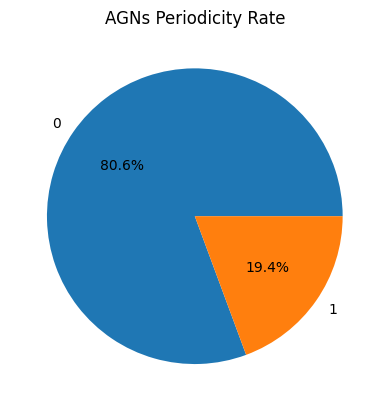

In [129]:
pie_x, pie_y = np.unique(dfn['Periodicity'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Periodicity Rate')
plt.show()

### Machine Learining Models

In [130]:
#Apply a Random Forest classifier with the original dataset.

data2 = features_df1.copy()

# Split the data into features and target
X = data2.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = data2['Periodicity']

# Split the dataset into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier2 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier2.fit(X2_train, y2_train)

# Make predictions on the test set
y2_pred = rf_classifier2.predict(X2_test)

# Evaluate the model
accuracy_score(y2_pred,y2_test)

1.0

In [131]:
#Another Machine Learning model, a Random Forest classifier with an undersampling.

# Split the data into features and target
X = dfn.drop('Periodicity', axis=1)[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt']]
y = dfn['Periodicity']

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify = y)

# Initialize the Random Forest Classifier
rf_classifier3 = RandomForestClassifier(max_depth=10)

# Train the model
rf_classifier3.fit(X3_train, y3_train)

# Make predictions on the test set
y3_pred = rf_classifier3.predict(X3_test)

# Evaluate the model
accuracy_score(y3_pred,y3_test)

1.0

#### We use the metrics to evaluate the model

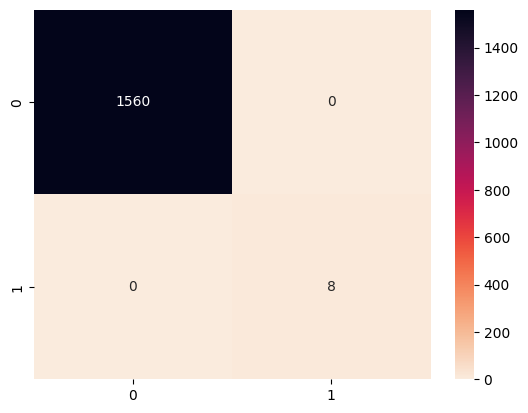

In [132]:
mc=confusion_matrix(y2_pred,y2_test)
mc_norm = mc / np.linalg.norm(mc, axis=1, keepdims=True)
sns.heatmap(pd.DataFrame(mc), cmap=sns.cm.rocket_r, annot=True, fmt='.5g');

In [133]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='precision')

array([1., 1., 1.])

In [134]:
cross_val_score(rf_classifier2,X2_train,y2_train,cv=3,scoring='precision').mean()

1.0

In [135]:
cross_val_score(rf_classifier2,X1_train,y1_train,cv=3,scoring='recall')

array([0.98275862, 0.93103448, 0.94736842])

In [136]:
cross_val_score(rf_classifier2,X1_train,y1_train,cv=3,scoring='recall').mean()

0.9537205081669691

In [137]:
cross_val_score(rf_classifier2,X_train,y_train,cv=3,scoring='f1')

array([0.96      , 0.97029703, 0.88659794])

In [138]:
cross_val_score(rf_classifier2,X_train,y_train,cv=3,scoring='f1').mean()

0.942330031669025

Metrics of second Random Forest Model

In [139]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='precision')

array([1., 1., 1.])

In [140]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='precision').mean()

1.0

In [141]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='recall')

array([1., 1., 1.])

In [142]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='recall').mean()

1.0

In [143]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='f1')

array([1., 1., 1.])

In [144]:
cross_val_score(rf_classifier3,X3_train,y3_train,cv=3,scoring='f1').mean()

1.0

#### The second Random Forest model its better, so we will use this one.

In [145]:
#Precision score
precision_score(y3_pred, y3_test)

1.0

In [146]:
#ROC AUC score
roc_auc_score(y3_pred,y3_test)

1.0

In [147]:
#Recall score
recall_score(y3_test, y3_pred) 

1.0

In [148]:
#F1 score
f1_score(y3_test, y3_pred) 

1.0

In [149]:
print(classification_report(y3_test,y3_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         5

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [151]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

path = '/home/anakin/Documents/Tesis/Codigo/obs/' #path to main directory
filelist = os.listdir(path)
df_obs = []
names1 = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.dat'):
            file = np.loadtxt(i+j, skiprows=5)
            long= len(file[:,0])

            data_features_obs = []

            star = agns1(file)[1]

            features_obs = dataframe_obs(file, star)

            # Store the features and the target variable
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_obs = pd.DataFrame(data_features_obs)

            # Predict with the model
            predicted = rf_classifier3.predict(features_df_obs)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is Periodic whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1

 # Save the DataFrame to a CSV file
df_obs.to_csv('observations_AGNs.csv', index=False)

1331_n1E4.dat :Classified [0] with 30 observations
1331_n1E5.dat :Classified [0] with 30 observations
1331_n1E12.dat :Classified [0] with 30 observations
1331_n1E10.dat :Classified [0] with 30 observations
1331_n1E9.dat :Classified [0] with 30 observations
1331_n1E2.dat :Classified [0] with 30 observations
1331_n1E3.dat :Classified [0] with 30 observations
1331_n1E6.dat :Classified [0] with 30 observations
1331_n1E11.dat :Classified [0] with 30 observations
------------------------------------------------- agn_1331 is Periodic whit a probability of: 0.0 %
1349_n1E14.dat :Classified [0] with 14 observations
1349_n1E15.dat :Classified [0] with 14 observations
1349_n1E12.dat :Classified [0] with 14 observations
1349_n1E8.dat :Classified [0] with 14 observations
1349_n1E17.dat :Classified [0] with 14 observations
1349_n1E20.dat :Classified [0] with 14 observations
1349_n1E10.dat :Classified [0] with 14 observations
1349_n1E5.dat :Classified [0] with 14 observations
1349_n1E9.dat :Classifie

In [152]:
df_obs

,mag_mean,mag_var,mag_skew,mag_kurt,AGN_n_obs
0,-0.078913,0.004096,3.790373,14.107390,0537_n1E3.dat
1,0.348208,0.005075,1.476175,3.139287,1243_n2E2.dat
2,0.264167,0.003743,0.361706,0.179522,1243_n2E8.dat
3,-0.012292,0.004965,1.198445,1.486387,1243_n2E13.dat
4,0.349909,0.004354,2.556895,7.918585,1741_n2E4.dat
5,0.349909,0.004354,2.556895,7.918585,1741_n2E6.dat
6,-0.165636,0.003481,1.022086,3.697173,1741_n2E8.dat
7,-0.326773,0.003513,0.249829,2.552569,1741_n2E18.dat
8,0.130800,0.006003,-1.241334,1.543714,1741_n1E14.dat
9,-0.177409,0.005390,1.607368,4.967913,1741_n2E20.dat
